In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch

In [12]:
df = pd.read_csv("events.csv")

/var/folders/mp/l7pc43ln25l8vb_t3fc17rlm0000gn/T/ipykernel_1977/3786853415.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("events.csv")


In [13]:
df.head()

,game_id,period,minute,second,expanded_minute,type,outcome_type,team_id,team,player_id,...,goal_mouth_z,blocked_x,blocked_y,qualifiers,is_touch,is_shot,is_goal,card_type,related_event_id,related_player_id
0,1821049.0,FirstHalf,0.0,NaN,0.0,OffsideGiven,Unsuccessful,32.0,Man Utd,300299.0,...,NaN,NaN,NaN,[],False,NaN,NaN,NaN,NaN,NaN
1,1821049.0,FirstHalf,0.0,0.0,0.0,Start,Successful,32.0,Man Utd,NaN,...,NaN,NaN,NaN,[],False,NaN,NaN,NaN,NaN,NaN
2,1821049.0,FirstHalf,0.0,0.0,0.0,Start,Successful,170.0,Fulham,NaN,...,NaN,NaN,NaN,[],False,NaN,NaN,NaN,NaN,NaN
3,1821049.0,FirstHalf,0.0,0.0,0.0,Pass,Successful,170.0,Fulham,243254.0,...,NaN,NaN,NaN,"[{'type': {'displayName': 'Zone', 'value': 56}...",True,NaN,NaN,NaN,NaN,NaN
4,1821049.0,FirstHalf,0.0,1.0,0.0,Pass,Successful,170.0,Fulham,297395.0,...,NaN,NaN,NaN,"[{'type': {'displayName': 'PassEndX', 'value':...",True,NaN,NaN,NaN,NaN,NaN


In [14]:
df['type'].unique()

array(['OffsideGiven', 'Start', 'Pass', 'BallTouch', 'TakeOn',
       'Challenge', 'BallRecovery', 'Tackle', 'OffsidePass',
       'OffsideProvoked', 'Aerial', 'Interception', 'Foul', 'Clearance',
       'Claim', 'GoodSkill', 'MissedShots', 'Dispossessed',
       'KeeperPickup', 'BlockedPass', 'SavedShot', 'Save',
       'CornerAwarded', 'Card', 'KeeperSweeper', 'Error', 'End', 'Punch',
       'ShieldBallOpp', 'SubstitutionOff', 'SubstitutionOn',
       'FormationChange', 'Goal', 'FormationSet', 'ShotOnPost', 'Smother',
       'PenaltyFaced', 'CrossNotClaimed', 'ChanceMissed', nan],
      dtype=object)

In [15]:
df = df[['x', 'y', 'end_x', 'end_y', 'type', 'is_shot', 'outcome_type']]
df.head()

,x,y,end_x,end_y,type,is_shot,outcome_type
0,58.4,95.3,NaN,NaN,OffsideGiven,NaN,Unsuccessful
1,0.0,0.0,NaN,NaN,Start,NaN,Successful
2,0.0,0.0,NaN,NaN,Start,NaN,Successful
3,49.9,49.9,39.2,46.7,Pass,NaN,Successful
4,39.2,46.7,24.2,36.7,Pass,NaN,Successful


In [25]:
passes = df[df['type'] == 'Pass']

(passes['outcome_type'] == 'Successful').sum() / len(passes)

np.float64(0.8169134442702202)

In [16]:

def map_coordinates_to_grid_vectorized(x, y, grid_width=16, grid_height=12):
    """
    Vectorized function to convert pitch coordinates (x, y) into grid cell indices,
    handling missing values.

    Parameters:
        x (pd.Series or np.array): X-coordinates on the pitch (normalized to 0-100).
        y (pd.Series or np.array): Y-coordinates on the pitch (normalized to 0-100).
        grid_width (int): Number of grid cells across the width of the pitch.
        grid_height (int): Number of grid cells across the height of the pitch.

    Returns:
        tuple: Two arrays (grid_x, grid_y) representing grid cell indices. Missing values
               will be represented as None.
    """
    PITCH_WIDTH = 100
    PITCH_HEIGHT = 100

    # Handle missing values (NaN or None)
    valid = ~pd.isna(x) & ~pd.isna(y)

    # Initialize arrays with None for invalid coordinates
    grid_x = np.full_like(x, None, dtype=object)
    grid_y = np.full_like(y, None, dtype=object)

    # Compute grid indices only for valid rows
    grid_x[valid] = np.floor(x[valid] * grid_width / PITCH_WIDTH).clip(0, grid_width - 1).astype(int)
    grid_y[valid] = np.floor(y[valid] * grid_height / PITCH_HEIGHT).clip(0, grid_height - 1).astype(int)

    return grid_x, grid_y

# Map starting coordinates to grid cells
df["grid_x"], df["grid_y"] = map_coordinates_to_grid_vectorized(df["x"], df["y"])

# Map ending coordinates to grid cells, handling missing values
df["grid_x_end"], df["grid_y_end"] = map_coordinates_to_grid_vectorized(df["end_x"], df["end_y"])

In [17]:
# Initialize the empty grids
GRID_HEIGHT, GRID_WIDTH = 12, 16

pass_count = np.zeros((GRID_HEIGHT, GRID_WIDTH))
shot_count = np.zeros((GRID_HEIGHT, GRID_WIDTH))
goal_count = np.zeros((GRID_HEIGHT, GRID_WIDTH))

# Filter events by type
pass_df = df.query("type == 'Pass'")
goals_df = df.query("type == 'Goal'")
shots_df = df.query("is_shot == True")

# Group by grid coordinates and count events
pass_counts = pass_df.groupby(["grid_y", "grid_x"]).size()
shot_counts = shots_df.groupby(["grid_y", "grid_x"]).size()
goal_counts = goals_df.groupby(["grid_y", "grid_x"]).size()

# Fill in the grids using the grouped data
for (y, x), count in pass_counts.items():
    pass_count[y, x] = count

for (y, x), count in shot_counts.items():
    shot_count[y, x] = count

for (y, x), count in goal_counts.items():
    goal_count[y, x] = count

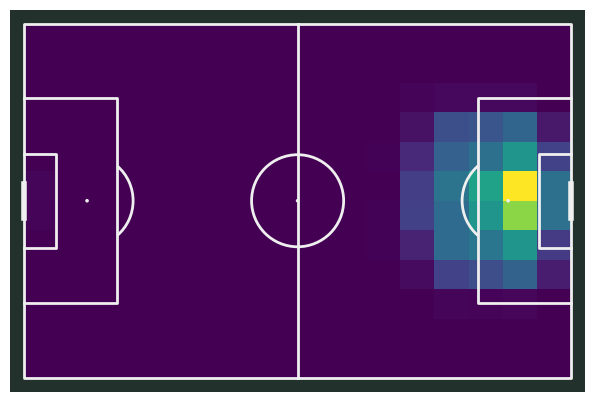

In [18]:
statistic = shot_count
y, x = statistic.shape
x_grid = np.linspace(0, 100, x + 1)
y_grid = np.linspace(0, 100, y + 1)
cx = x_grid[:-1] + 0.5 * (x_grid[1] - x_grid[0])
cy = y_grid[:-1] + 0.5 * (y_grid[1] - y_grid[0])
stats = dict(statistic=statistic, x_grid=x_grid, y_grid=y_grid, cx=cx, cy=cy)

pitch = Pitch(pitch_type='opta', line_zorder=2, pitch_color='#22312b', line_color='#efefef')
fig, ax = pitch.draw(figsize=(8, 4.125))

pcm = pitch.heatmap(stats, ax=ax, cmap='viridis')

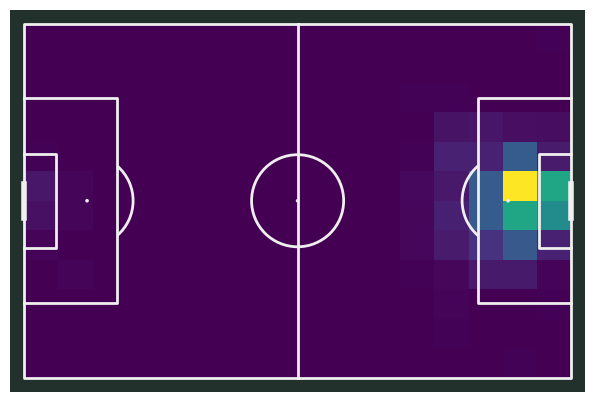

In [19]:
statistic = goal_count
y, x = statistic.shape
x_grid = np.linspace(0, 100, x + 1)
y_grid = np.linspace(0, 100, y + 1)
cx = x_grid[:-1] + 0.5 * (x_grid[1] - x_grid[0])
cy = y_grid[:-1] + 0.5 * (y_grid[1] - y_grid[0])
stats = dict(statistic=statistic, x_grid=x_grid, y_grid=y_grid, cx=cx, cy=cy)

pitch = Pitch(pitch_type='opta', line_zorder=2, pitch_color='#22312b', line_color='#efefef')
fig, ax = pitch.draw(figsize=(8, 4.125))

pcm = pitch.heatmap(stats, ax=ax, cmap='viridis')

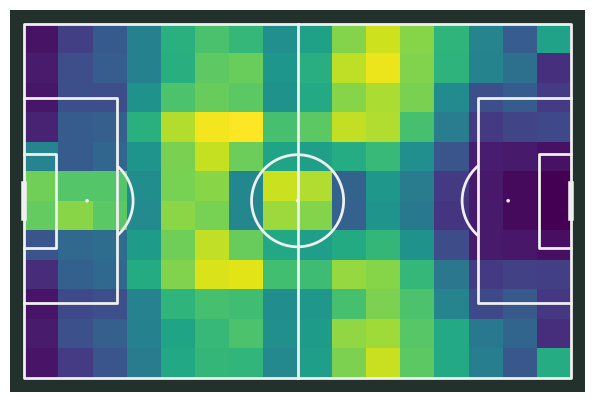

In [20]:
statistic = pass_count
y, x = statistic.shape
x_grid = np.linspace(0, 100, x + 1)
y_grid = np.linspace(0, 100, y + 1)
cx = x_grid[:-1] + 0.5 * (x_grid[1] - x_grid[0])
cy = y_grid[:-1] + 0.5 * (y_grid[1] - y_grid[0])
stats = dict(statistic=statistic, x_grid=x_grid, y_grid=y_grid, cx=cx, cy=cy)

pitch = Pitch(pitch_type='opta', line_zorder=2, pitch_color='#22312b', line_color='#efefef')
fig, ax = pitch.draw(figsize=(8, 4.125))

pcm = pitch.heatmap(stats, ax=ax, cmap='viridis')

In [28]:
with np.errstate(divide='ignore', invalid='ignore'):
    move_probability = pass_count / (pass_count + shot_count)
    shot_probability = shot_count / (pass_count + shot_count)
    goal_probability = goal_count / shot_count
    goal_probability = np.nan_to_num(goal_probability, nan=0.0, posinf=0.0, neginf=0.0)
    move_probability *= 0.82 #this could be improved, e.g. using different values for different regions of the pitch

In [29]:
# Aggregate passes by start and end grid locations
pass_end_aggs = (
    pass_df
    .groupby(["grid_x", "grid_y", "grid_x_end", "grid_y_end"])
    .size()
    .reset_index(name="count_end")  # Count passes ending at each location
)

pass_start_aggs = (
    pass_df
    .groupby(["grid_x", "grid_y"])
    .size()
    .reset_index(name="count_start")  # Count passes starting from each location
)

# Merge the start and end aggregates and calculate pass probabilities
pass_aggs = pass_end_aggs.merge(pass_start_aggs, on=["grid_x", "grid_y"], how="left")
pass_aggs["pass_prob"] = pass_aggs["count_end"] / pass_aggs["count_start"]

# Drop unnecessary columns
pass_aggs = pass_aggs.drop(columns=["count_end", "count_start"])

# Initialize the transition matrices
GRID_HEIGHT, GRID_WIDTH = 12, 16
t_matrices = np.zeros((GRID_HEIGHT, GRID_WIDTH, GRID_HEIGHT, GRID_WIDTH))

# Populate the transition matrices
for _, row in pass_aggs.iterrows():
    start_x, start_y = int(row["grid_x"]), int(row["grid_y"])
    end_x, end_y = int(row["grid_x_end"]), int(row["grid_y_end"])
    t_matrices[start_y, start_x, end_y, end_x] = row["pass_prob"]

In [30]:
N_CELLS = GRID_WIDTH * GRID_HEIGHT

# Flatten input probabilities
shot_prob_flat = shot_probability.flatten()
goal_prob_flat = goal_probability.flatten()
move_prob_flat = move_probability.flatten()

# Initialize matrix A as an identity matrix
A = np.eye(N_CELLS)

# Compute adjustments to A for movement probabilities and transitions
for i in range(N_CELLS):
    # Map flat index to grid coordinates
    y, x = divmod(i, GRID_WIDTH)

    # Subtract the scaled transition matrix from A
    A[i] -= move_prob_flat[i] * t_matrices[y, x].flatten()

# Create vector b (shooting payoff)
b = shot_prob_flat * goal_prob_flat

# Solve the linear system A * x = b
xt_grid_flat = np.linalg.solve(A, b)

# Reshape the result into the grid format
xt_grid = xt_grid_flat.reshape(GRID_HEIGHT, GRID_WIDTH)

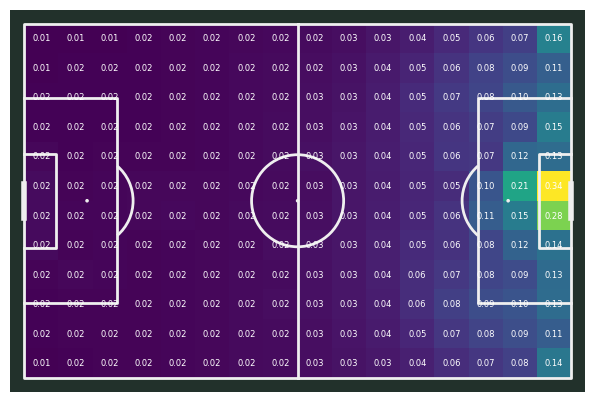

In [31]:
statistic = xt_grid

y, x = statistic.shape
x_grid = np.linspace(0, 100, x + 1)
y_grid = np.linspace(0, 100, y + 1)
cx = x_grid[:-1] + 0.5 * (x_grid[1] - x_grid[0])
cy = y_grid[:-1] + 0.5 * (y_grid[1] - y_grid[0])
stats = dict(statistic=statistic, x_grid=x_grid, y_grid=y_grid, cx=cx, cy=cy)

pitch = Pitch(pitch_type='opta', line_zorder=2, pitch_color='#22312b', line_color='#efefef')
fig, ax = pitch.draw(figsize=(8, 4.125))

pcm = pitch.heatmap(stats, ax=ax, cmap='viridis')

for i, row in enumerate(statistic):
    for j, val in enumerate(row):
        ax.text(cx[j], cy[i], f'{val:.2f}', ha='center', va='center', color='white', fontsize=6)

In [39]:
# Load the data
player_df = pd.read_csv("events.csv")

# Map the coordinates to the grid
player_df["grid_x"], player_df["grid_y"] = map_coordinates_to_grid_vectorized(player_df["x"], player_df["y"])
player_df["grid_x_end"], player_df["grid_y_end"] = map_coordinates_to_grid_vectorized(player_df["end_x"], player_df["end_y"])

# Filter out rows with missing grid values
player_df = player_df.dropna(subset=["grid_x", "grid_y", "grid_x_end", "grid_y_end"])

# Calculate the xT difference per action (vectorized)
player_df["xt_diff"] = (
    xt_grid[player_df["grid_y_end"].astype(int).values, player_df["grid_x_end"].astype(int).values] -
    xt_grid[player_df["grid_y"].astype(int).values, player_df["grid_x"].astype(int).values]
)

# Filter for positive xT differences and aggregate by player
top_players = (
    player_df.query("xt_diff > 0")
    .groupby(["player_id", "player"], as_index=False)["xt_diff"]
    .sum()
    .sort_values("xt_diff", ascending=False)
    .head(10)
)
top_players

#focus on the goals as well

/var/folders/mp/l7pc43ln25l8vb_t3fc17rlm0000gn/T/ipykernel_1977/2482152096.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  player_df = pd.read_csv("events.csv")


,player_id,player,xt_diff
95,123761.0,Bruno Fernandes,42.327079
202,318871.0,Trent Alexander-Arnold,38.323443
282,353377.0,Bryan Mbeumo,33.318630
393,401168.0,Mikkel Damsgaard,32.770428
300,362352.0,Pedro Porro,31.899764
112,136345.0,Youri Tielemans,30.768800
374,395692.0,Cole Palmer,30.594820
233,332325.0,Declan Rice,28.537208
121,136824.0,Alex Iwobi,28.276380
326,369430.0,Enzo Fernández,27.979149
